In [45]:
import numpy as np
import torch
import torch.utils.data as data
from  torchvision import transforms
import matplotlib.pyplot as plt
import medmnist
from medmnist import BloodMNIST
from medmnist import INFO
import time
import torch.nn.functional as F
import os
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [46]:
class BloodCellClassifier(nn.Module):
    def __init__(self):
        super(BloodCellClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))  
        x = x.view(-1, 64 * 7 * 7)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# original bloodMNIST

In [47]:
info = INFO['bloodmnist']
task = info['task']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

trainset = DataClass(split='train', transform=transforms.ToTensor(), download=True)
testset = DataClass(split='test', transform=transforms.ToTensor(), download=True)

train_dataloader = data.DataLoader(dataset=trainset, batch_size=128, shuffle=True)
test_dataloader = data.DataLoader(dataset=testset, batch_size=128, shuffle=False)

def extract_unique_labels(dataset):
    unique_labels = set()
    for _, label in dataset:
        if isinstance(label, np.ndarray):
            label = int(label[0])
        unique_labels.add(label)
    return sorted(list(unique_labels))

classes=extract_unique_labels(trainset)

label_counts = {}

for data, target in train_dataloader:
    for label in target:
        label = label.item() 
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

for label, count in label_counts.items():
    print(f'Label {label}: {count} images')

Label 7: 1643 images
Label 6: 2330 images
Label 3: 2026 images
Label 1: 2181 images
Label 4: 849 images
Label 2: 1085 images
Label 5: 993 images
Label 0: 852 images


In [48]:
class FixedBloodMNIST(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]

        if isinstance(label, np.ndarray):
            label = int(label.item())
        label = torch.tensor(label, dtype=torch.long)

        return image, label

trainset = FixedBloodMNIST(trainset)

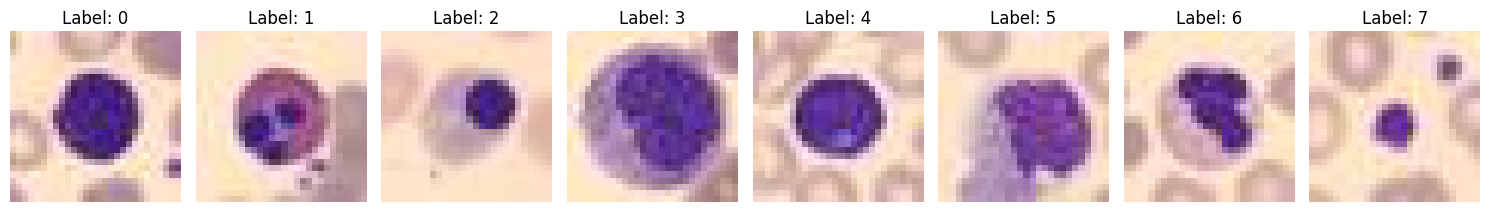

In [49]:
plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(trainset)):
    image, label = trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [50]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epoch_losses = []
epoch_acc = []
num_epochs=10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        images = images.to(device)
        labels = labels.squeeze().long().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    epoch_acc.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/10, Loss: 1.3725, Accuracy: 50.19%
Epoch 2/10, Loss: 0.8338, Accuracy: 71.00%
Epoch 3/10, Loss: 0.7270, Accuracy: 74.36%
Epoch 4/10, Loss: 0.6145, Accuracy: 78.23%
Epoch 5/10, Loss: 0.5145, Accuracy: 82.08%
Epoch 6/10, Loss: 0.4686, Accuracy: 83.83%
Epoch 7/10, Loss: 0.4205, Accuracy: 85.37%
Epoch 8/10, Loss: 0.4015, Accuracy: 85.80%
Epoch 9/10, Loss: 0.3689, Accuracy: 86.74%
Epoch 10/10, Loss: 0.3511, Accuracy: 87.35%


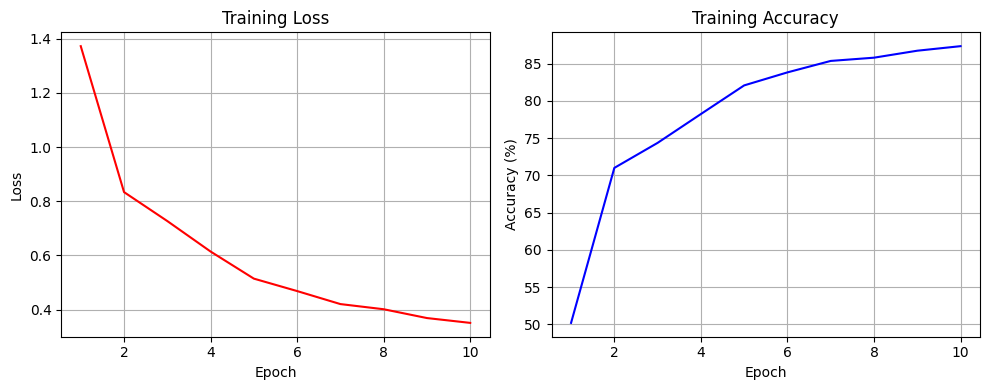

In [51]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(range(1, num_epochs+1), epoch_losses, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, num_epochs+1), epoch_acc, color='blue')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()

# generated bloodMNIST

In [52]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path)  # shape: (N, H, W, 3)
        self.labels = np.load(label_path)  # shape: (N,)
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]

        # Ensure image is uint8 RGB
        if image.dtype != np.uint8:
            image = (image * 255).astype(np.uint8)

        if image.ndim == 2:  # in case of grayscale
            image = Image.fromarray(image).convert("RGB")
        else:
            image = Image.fromarray(image)

        if self.transform:
            image = self.transform(image)

        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return image, label

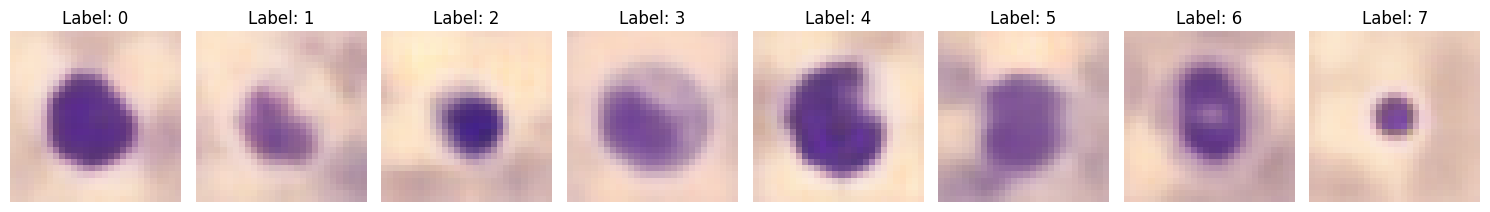

In [53]:
class GeneratedBloodMNIST(Dataset):
    def __init__(self, data_path, label_path, transform=None):
        self.images = np.load(data_path) 
        self.labels = np.load(label_path)  
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx]) 
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        if self.transform:
            image = self.transform(image)
        return image, label


generated_trainset = GeneratedBloodMNIST(
    data_path='./generated_blood_cell_images1/generated_train_data.npy',
    label_path='./generated_blood_cell_images1/generated_train_labels.npy',
    transform=transforms.ToTensor()
)

generated_train_loader = DataLoader(generated_trainset, batch_size=128, shuffle=True)

plt.figure(figsize=(15, 5))

encountered_labels = [False] * n_classes

for i in range(len(generated_trainset)):
    image, label = generated_trainset[i]

    label = int(label)

    if not encountered_labels[label]:
        plt.subplot(1, n_classes, label+1)
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f'Label: {classes[label]}')
        plt.axis('off')

        encountered_labels[label] = True
    if all(encountered_labels):
        break

plt.tight_layout()
plt.show()

In [55]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
epoch_losses = []
epoch_acc = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in generated_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_dataloader)
    epoch_losses.append(avg_loss)
    epoch_acc.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/10, Loss: 94.8018, Accuracy: 46.77%
Epoch 2/10, Loss: 37.5366, Accuracy: 78.55%
Epoch 3/10, Loss: 27.1738, Accuracy: 84.08%
Epoch 4/10, Loss: 22.3223, Accuracy: 87.45%
Epoch 5/10, Loss: 21.1885, Accuracy: 87.95%
Epoch 6/10, Loss: 17.0357, Accuracy: 90.56%
Epoch 7/10, Loss: 15.5678, Accuracy: 91.46%
Epoch 8/10, Loss: 15.4044, Accuracy: 91.44%
Epoch 9/10, Loss: 12.8994, Accuracy: 92.79%
Epoch 10/10, Loss: 12.4956, Accuracy: 93.03%


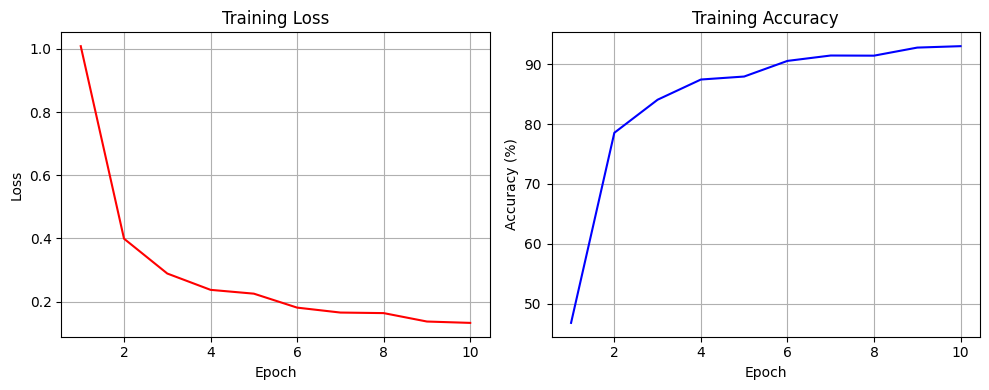

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(range(1, num_epochs+1), epoch_losses, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, num_epochs+1), epoch_acc, color='blue')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [57]:
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms
import medmnist
from medmnist import INFO

# combined

In [58]:
combined_trainset = ConcatDataset([trainset, generated_trainset])

combined_train_loader = DataLoader(combined_trainset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=128, shuffle=False)


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BloodCellClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
epoch_losses = []
epoch_acc = []


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in combined_train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(combined_train_loader)
    epoch_losses.append(avg_loss)
    epoch_acc.append(acc)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss:.4f}, Accuracy: {acc:.2f}%")


Epoch 1/10, Loss: 187.3833, Accuracy: 56.88%
Epoch 2/10, Loss: 115.1623, Accuracy: 74.41%
Epoch 3/10, Loss: 92.1482, Accuracy: 79.26%
Epoch 4/10, Loss: 76.1469, Accuracy: 83.58%
Epoch 5/10, Loss: 64.9216, Accuracy: 85.92%
Epoch 6/10, Loss: 57.1351, Accuracy: 87.40%
Epoch 7/10, Loss: 50.3184, Accuracy: 88.99%
Epoch 8/10, Loss: 44.3738, Accuracy: 90.43%
Epoch 9/10, Loss: 41.2860, Accuracy: 91.04%
Epoch 10/10, Loss: 37.8079, Accuracy: 91.85%


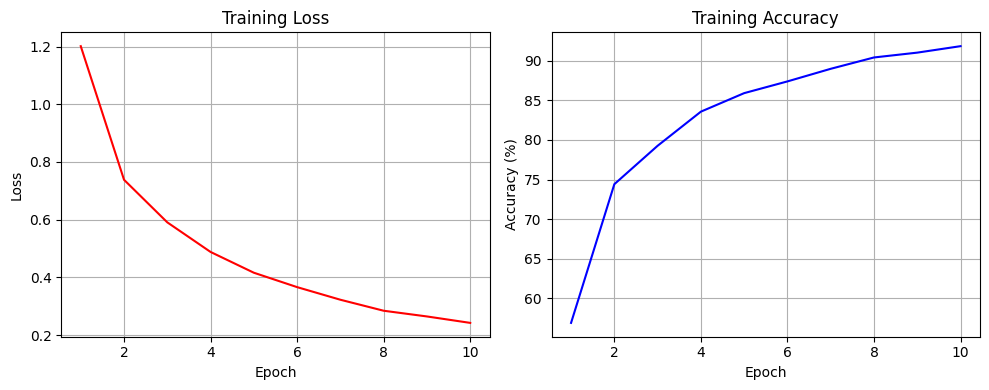

In [60]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

ax1.plot(range(1, num_epochs+1), epoch_losses, color='red')
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

ax2.plot(range(1, num_epochs+1), epoch_acc, color='blue')
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()
